<a href="https://colab.research.google.com/github/duwi27sulis/Analisis_Data_LSTM/blob/main/H1_T1_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install optuna

In [29]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [30]:
# Fix random seed for reproducibility
tf.random.set_seed(42)
plt.rcParams['figure.figsize'] = (16,6)

In [31]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
data = df['Nilai Ekspor Migas'].values.astype('float32').reshape(-1, 1)

In [32]:
# Statistik Deskriptif
df['Nilai Ekspor Migas'].describe()

count     276.000000
mean     1676.342029
std       768.702279
min       560.900000
25%      1122.675000
50%      1422.750000
75%      2101.000000
max      4091.600000
Name: Nilai Ekspor Migas, dtype: float64

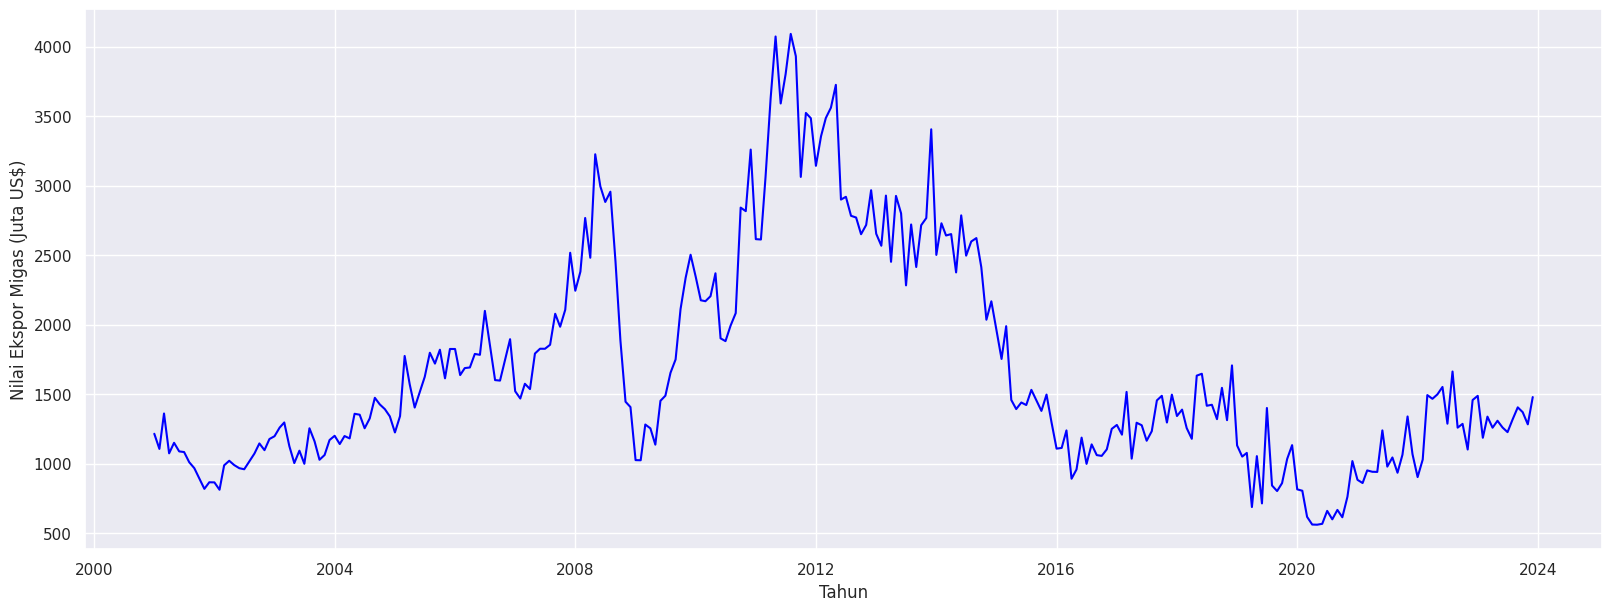

In [33]:
# Line plot data time series
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
    xs = series['Tanggal']
    ys = series['Nilai Ekspor Migas']

    plt.plot(xs, ys, label=series_name, color='blue')

fig, ax = plt.subplots(figsize=(16, 6), layout='constrained')
df_sorted = df.sort_values('Tanggal', ascending=True)
_plot_series(df_sorted, '')

# Menambahkan bingkai kotak
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

sns.despine(fig=fig, ax=ax, top=False, right=False, bottom=False, left=False)
plt.xlabel('Tahun')
_ = plt.ylabel('Nilai Ekspor Migas (Juta US$)')

plt.show()

In [34]:
# Uji kestasioneran (Augmented Dickey-Fuller Test)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

result_original = sm.tsa.adfuller(data)
print('ADF Statistic :', result_original[0])
print('p-value :', result_original[1])
print('Critical :')
for key, value in result_original[4].items():
    print(f'   {key}: {value}')

ADF Statistic : -2.0481781387920948
p-value : 0.2658560561741424
Critical :
   1%: -3.4544435065994437
   5%: -2.8721468827772774
   10%: -2.572422013959188


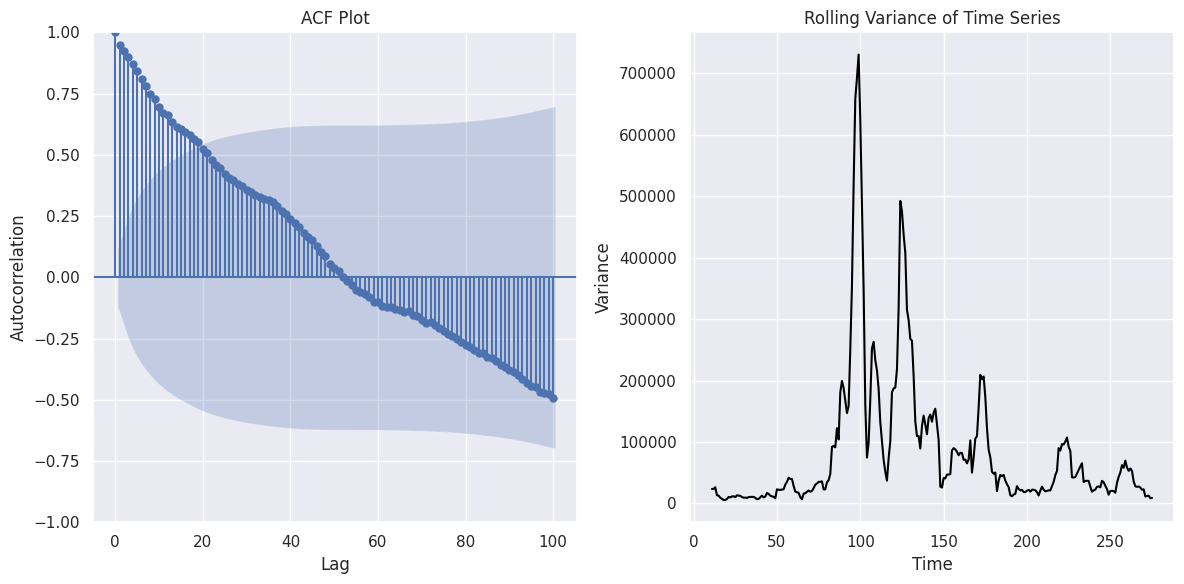

In [35]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Mengatur gaya seaborn
sns.set()

# Mengambil kolom 'Nilai Ekspor Migas' sebagai series
series = df['Nilai Ekspor Migas']

# Membuat ACF Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(series, ax=ax[0], lags=100)
ax[0].set_title('ACF Plot')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

# Menghitung varians bergulir dengan window size 12 (misal: bulanan untuk data tahunan)
rolling_variance = series.rolling(window=12).var()

# Membuat plot rolling variance
ax[1].plot(rolling_variance, color='black')
ax[1].set_title('Rolling Variance of Time Series')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Variance')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [36]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [37]:
# Fungsi untuk membuat dataset
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

In [38]:
# Prepare data
time_steps = 1
X, y = create_dataset(scaled_data, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [39]:
# Split data into training and testing sets
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size, :], X[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape, sep='\n')

(233, 1, 1)
(42, 1, 1)


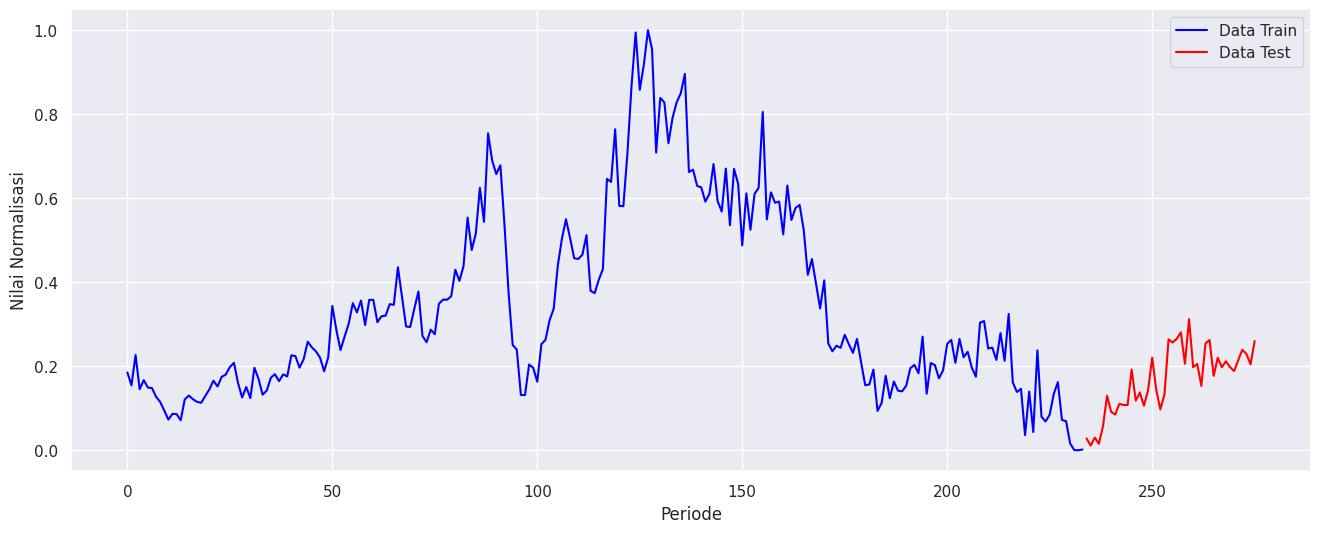

In [40]:
plt.figure(figsize=(16, 6))

bagi_train = int(len(scaled_data)*0.85)
bagi_test = len(scaled_data) - bagi_train
Xnorm_train, Xnorm_test = scaled_data[:bagi_train, :], scaled_data[bagi_train:, :]

# Plot X_train setelah normalisasi
plt.plot(range(len(Xnorm_train)), Xnorm_train, color='blue', label='Data Train')

# Plot X_test setelah normalisasi (dimulai dari akhir X_train)
plt.plot(range(len(Xnorm_train), len(Xnorm_train) + len(Xnorm_test)), Xnorm_test, color='red', label='Data Test')

# Menambahkan label dan legenda
plt.xlabel('Periode')
plt.ylabel('Nilai Normalisasi')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

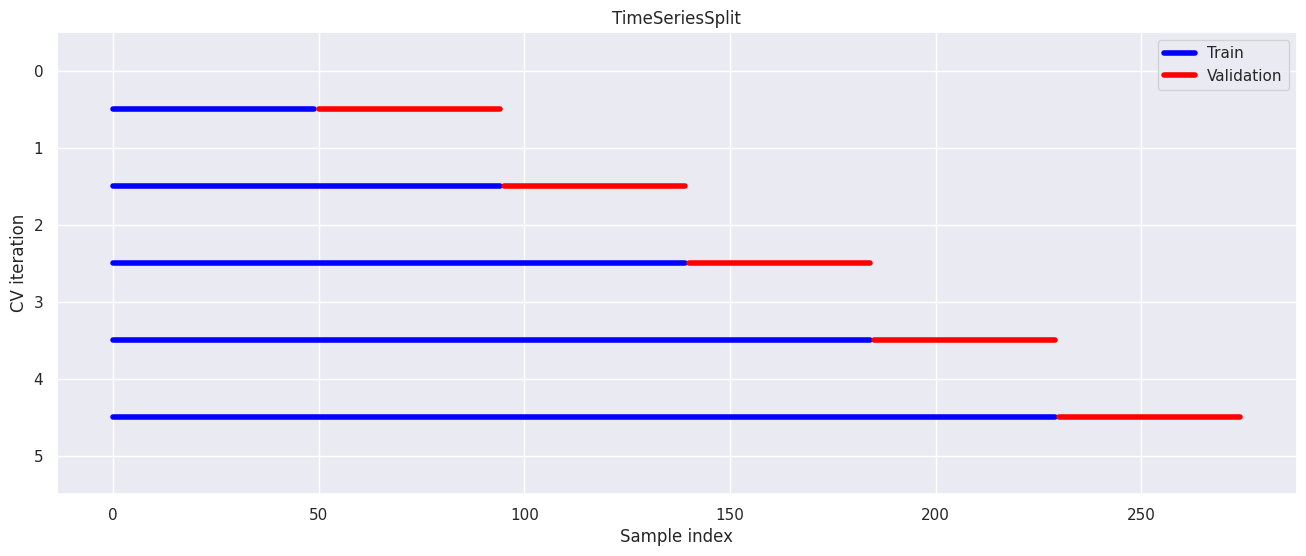

In [42]:
# Visualisasi TimeSeriesSplit
def plot_time_series_cv(tscv, X):
    plt.figure(figsize=(16, 6))
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        indices = np.arange(len(X))
        plt.plot(indices[train_index], [i + 0.5] * len(train_index), color = 'blue', linewidth = '4.0', label='Train' if i == 0 else '')
        plt.plot(indices[test_index], [i + 0.5] * len(test_index), color = 'red', linewidth = '4.0', label='Validation' if i == 0 else '')
    plt.ylim(-0.5, tscv.get_n_splits(X) + 0.5)
    plt.title('TimeSeriesSplit')
    plt.xlabel('Sample index')
    plt.ylabel('CV iteration')
    plt.legend(loc='best')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the smallest CV iteration at the top
    plt.show()

# Plot the TimeSeriesSplit
plot_time_series_cv(tscv, X)

In [43]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [44]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

    return np.mean(cv_scores)

In [45]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-07-08 08:03:12,071] A new study created in memory with name: no-name-35a16d5e-29f4-4312-881c-bcc0bd8b311d


2/2 [==============================] - 1s 8ms/step


2/2 [==============================] - 0s 8ms/step


[I 2024-07-08 08:03:48,344] Trial 0 finished with value: 0.012148983776569366 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.012148983776569366.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:04:20,342] Trial 1 finished with value: 0.010465972125530243 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 1s 9ms/step


[I 2024-07-08 08:04:58,050] Trial 2 finished with value: 0.013449652120471 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 1s 8ms/step


[I 2024-07-08 08:05:35,225] Trial 3 finished with value: 0.018024470657110214 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:06:32,001] Trial 4 finished with value: 0.15330645442008972 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:07:26,173] Trial 5 finished with value: 0.0722050666809082 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:08:11,627] Trial 6 finished with value: 0.06980172544717789 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:08:44,594] Trial 7 finished with value: 0.16600781679153442 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 1s 5ms/step


[I 2024-07-08 08:09:23,415] Trial 8 finished with value: 0.0122044263407588 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 1s 6ms/step


[I 2024-07-08 08:09:52,610] Trial 9 finished with value: 0.013715142384171486 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 1s 6ms/step


[I 2024-07-08 08:10:25,463] Trial 10 finished with value: 0.011900393292307854 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 1s 10ms/step


[I 2024-07-08 08:10:58,294] Trial 11 finished with value: 0.012940222397446632 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:11:26,030] Trial 12 finished with value: 0.011313403025269508 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 1s 6ms/step


[I 2024-07-08 08:12:02,476] Trial 13 finished with value: 0.011823954991996288 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:12:33,759] Trial 14 finished with value: 0.01335279829800129 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.010465972125530243.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:13:10,612] Trial 15 finished with value: 0.008785286918282509 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 1s 10ms/step


[I 2024-07-08 08:13:43,793] Trial 16 finished with value: 0.011478576809167862 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 1s 11ms/step


[I 2024-07-08 08:14:11,466] Trial 17 finished with value: 0.017192741855978966 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:14:45,067] Trial 18 finished with value: 0.015106318518519402 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 1s 8ms/step


[I 2024-07-08 08:15:22,291] Trial 19 finished with value: 0.042550913989543915 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:15:50,504] Trial 20 finished with value: 0.01285942830145359 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 1s 9ms/step


[I 2024-07-08 08:16:22,091] Trial 21 finished with value: 0.011522764340043068 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:16:56,999] Trial 22 finished with value: 0.010536523535847664 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 1s 10ms/step


[I 2024-07-08 08:17:26,947] Trial 23 finished with value: 0.012786580249667168 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:18:02,662] Trial 24 finished with value: 0.009837379679083824 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 0s 5ms/step


[I 2024-07-08 08:18:38,088] Trial 25 finished with value: 0.013485977426171303 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 1s 7ms/step


[I 2024-07-08 08:19:11,839] Trial 26 finished with value: 0.008833433501422405 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.008785286918282509.


2/2 [==============================] - 1s 10ms/step


[I 2024-07-08 08:19:39,918] Trial 27 finished with value: 0.008664319291710854 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:20:20,293] Trial 28 finished with value: 0.05540331453084946 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:21:13,744] Trial 29 finished with value: 0.009904129430651665 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:21:46,642] Trial 30 finished with value: 0.010590961202979088 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:22:20,081] Trial 31 finished with value: 0.011150456964969635 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:22:51,724] Trial 32 finished with value: 0.010435749776661396 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:23:21,522] Trial 33 finished with value: 0.01107145007699728 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:23:51,035] Trial 34 finished with value: 0.009374046698212624 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:24:22,060] Trial 35 finished with value: 0.07562310993671417 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 9ms/step


[I 2024-07-08 08:24:55,685] Trial 36 finished with value: 0.009723800234496593 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:25:22,345] Trial 37 finished with value: 0.10112456977367401 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:25:57,603] Trial 38 finished with value: 0.023257087916135788 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:26:42,959] Trial 39 finished with value: 0.009534170851111412 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 1s 11ms/step


[I 2024-07-08 08:27:37,540] Trial 40 finished with value: 0.07475756108760834 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 12ms/step


[I 2024-07-08 08:28:15,739] Trial 41 finished with value: 0.008737677708268166 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:28:51,661] Trial 42 finished with value: 0.008864677511155605 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-08 08:29:27,612] Trial 43 finished with value: 0.009525190107524395 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:30:05,289] Trial 44 finished with value: 0.009380892850458622 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:30:48,331] Trial 45 finished with value: 0.008729873225092888 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:31:29,614] Trial 46 finished with value: 0.016138028353452682 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-08 08:32:07,664] Trial 47 finished with value: 0.013404570519924164 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.008664319291710854.


2/2 [==============================] - 1s 9ms/step


[I 2024-07-08 08:32:50,309] Trial 48 finished with value: 0.007146804127842188 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 48 with value: 0.007146804127842188.


2/2 [==============================] - 1s 10ms/step


[I 2024-07-08 08:33:28,281] Trial 49 finished with value: 0.007198455277830362 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 48 with value: 0.007146804127842188.


Best parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}
Best value: 0.007146804127842188


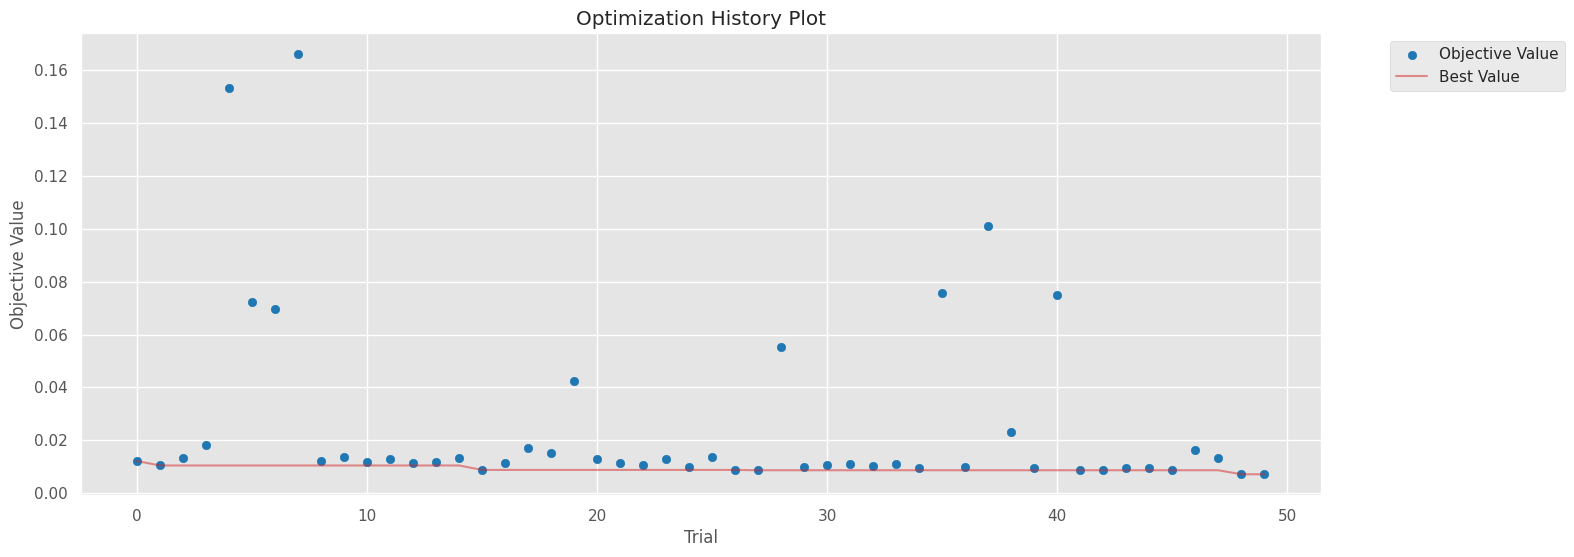

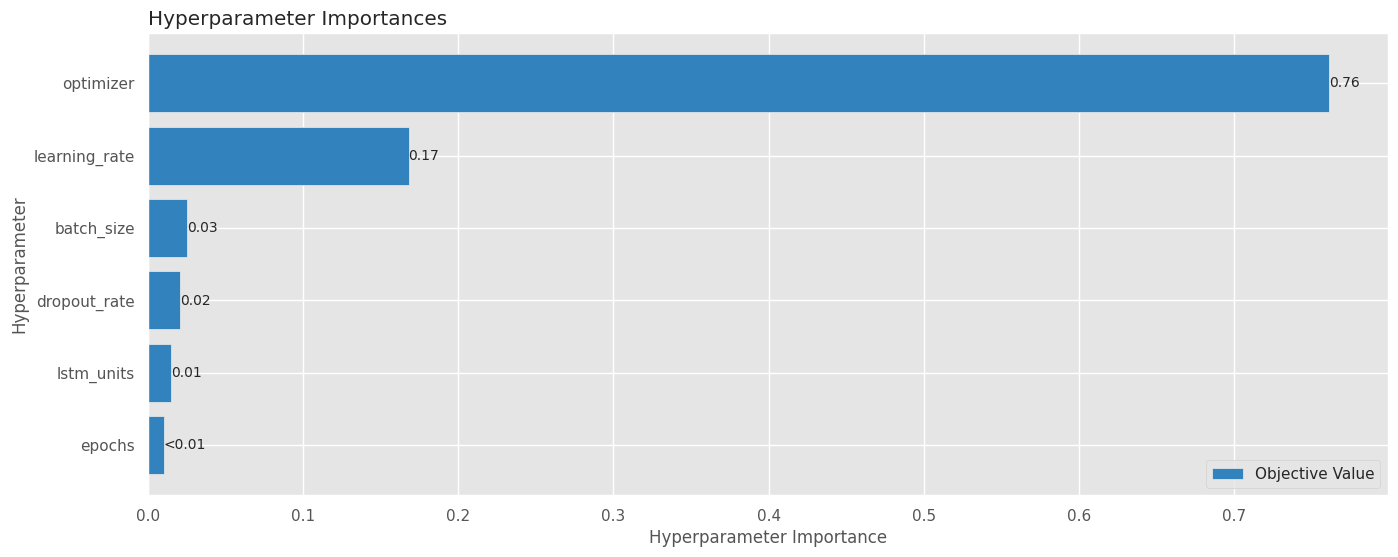

In [46]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [61]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/150
3/3 [==============================] - 3s 279ms/step - loss: 0.1609 - val_loss: 0.0061
Epoch 2/150
3/3 [==============================] - 0s 25ms/step - loss: 0.0512 - val_loss: 0.0332
Epoch 3/150
3/3 [==============================] - 0s 20ms/step - loss: 0.0307 - val_loss: 0.0868
Epoch 4/150
3/3 [==============================] - 0s 21ms/step - loss: 0.0464 - val_loss: 0.0669
Epoch 5/150
3/3 [==============================] - 0s 21ms/step - loss: 0.0280 - val_loss: 0.0276
Epoch 6/150
3/3 [==============================] - 0s 24ms/step - loss: 0.0204 - val_loss: 0.0106
Epoch 7/150
3/3 [==============================] - 0s 35ms/step - loss: 0.0229 - val_loss: 0.0077
Epoch 8/150
3/3 [==============================] - 0s 22ms/step - loss: 0.0203 - val_loss: 0.0104
Epoch 9/150
3/3 [==============================] - 0s 20ms/step - loss: 0.0132 - val_loss: 0.0165
Epoch 10/150
3/3 [==============================] - 0s 22ms/step - loss: 0.0123 - val_loss: 0.0195
Epoch 11/150
3/3 [

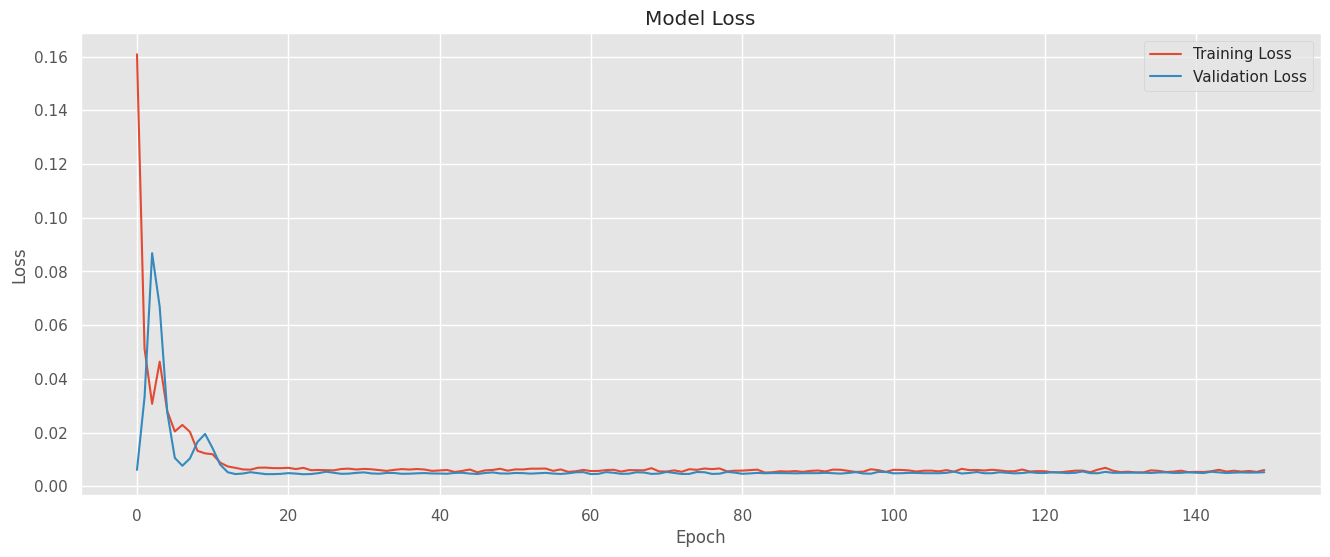

Average Loss: 0.0083


In [62]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [68]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [69]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [70]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [71]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 185.800
Root Mean Square Error: 254.686
Mean Absolute Percentage Error: 11.228%

evaluasi model data test:
Mean Absolute Error: 146.841
Root Mean Square Error: 190.219
Mean Absolute Percentage Error: 12.946%



In [72]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

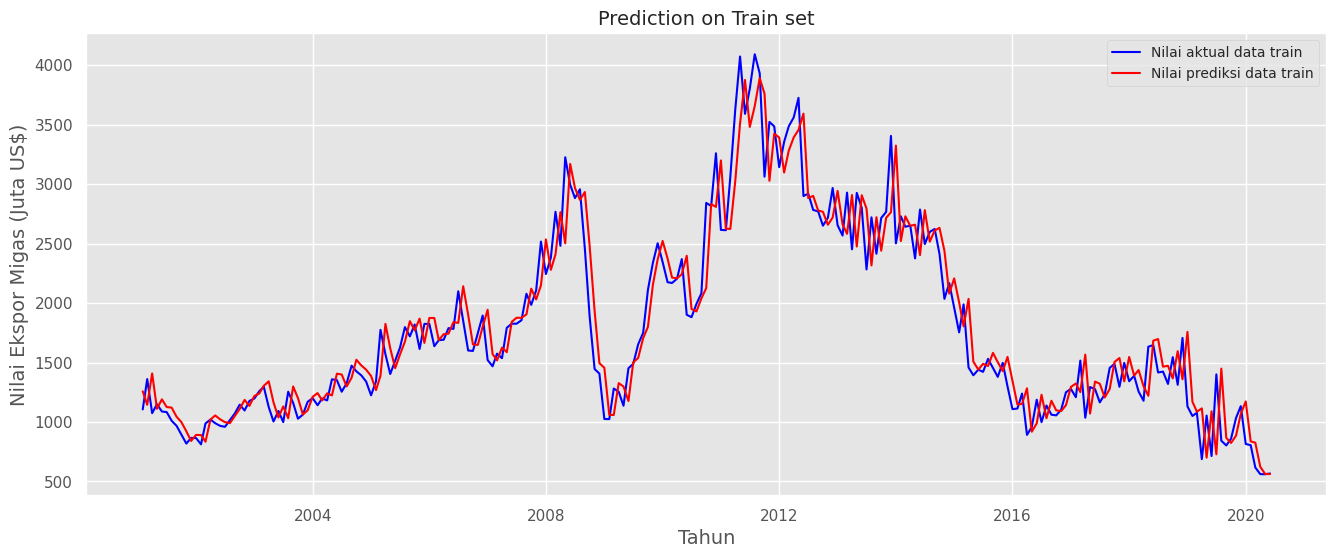

In [74]:
# Visualisasi prediksi vs aktual on train data
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Tahun', fontsize=14)
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=14)
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.show()

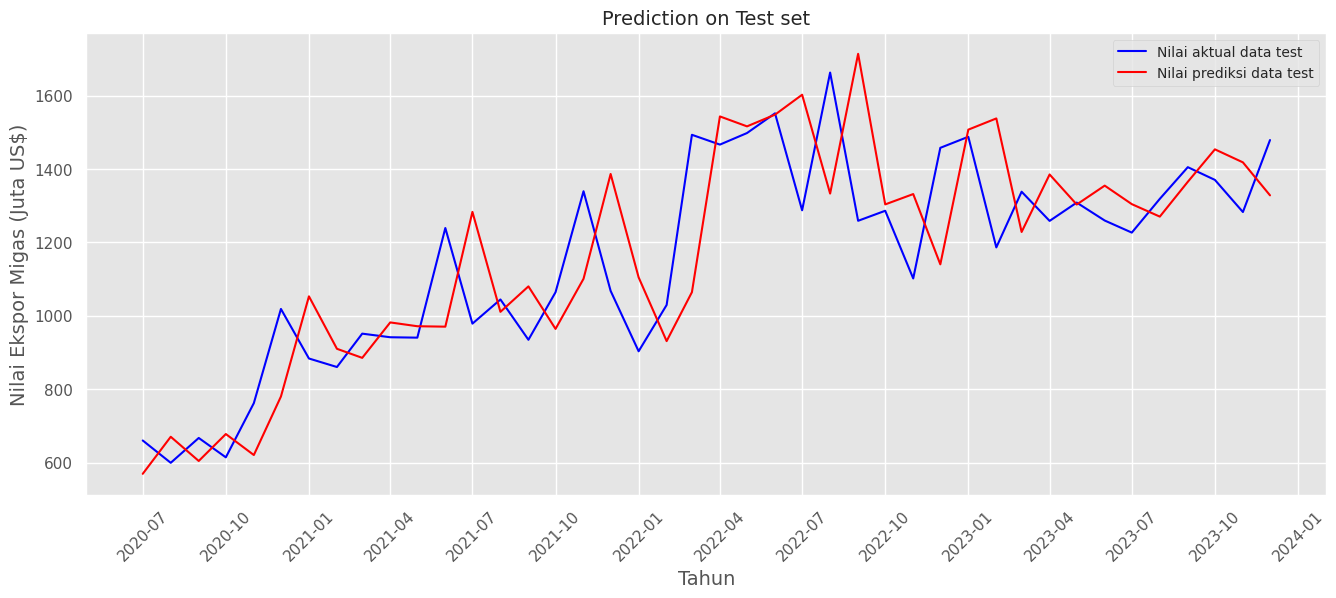

In [78]:
import matplotlib.dates as mdates

# Visualisasi prediksi vs aktual on test data
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Tahun', fontsize=14)
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=14)
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.show()

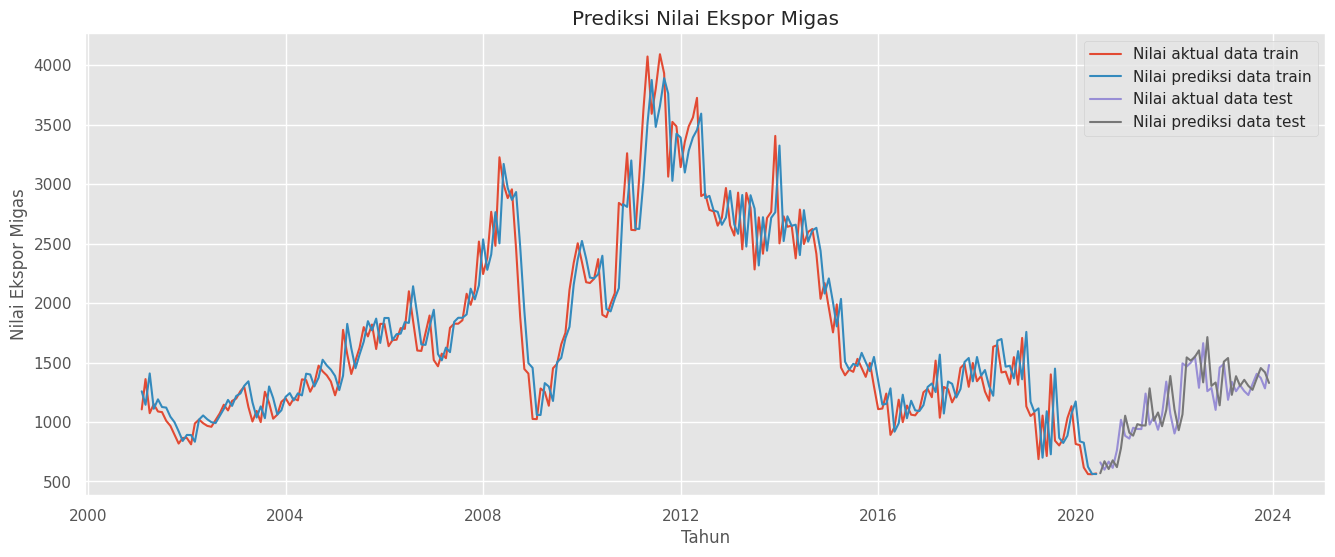

In [79]:
# Plot results
plt.figure(figsize=(16,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun')
plt.ylabel('Nilai Ekspor Migas')
plt.legend(fontsize=10)
plt.legend()
plt.show()

1/1 [==============================] - 0s 30ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1528.843262
1  2024-02-01                     1579.287720
2  2024-03-01                     1630.123291
3  2024-04-01                     1681.132935
4  2024-05-01                     1732.093628
5  2024-06-01                     1782.781250
6  2024-07-01                     1832.975830
7  2024-08-01                     1882.463501
8  2024-09-01                     1931.041382
9  2024-10-01                     1978.520752
10 2024-11-01                     2024.729736
11 2024-12-01                     2069.515625


Text(0.5, 1.0, 'Nilai Ekspor Migas Prediction (Including Future)')

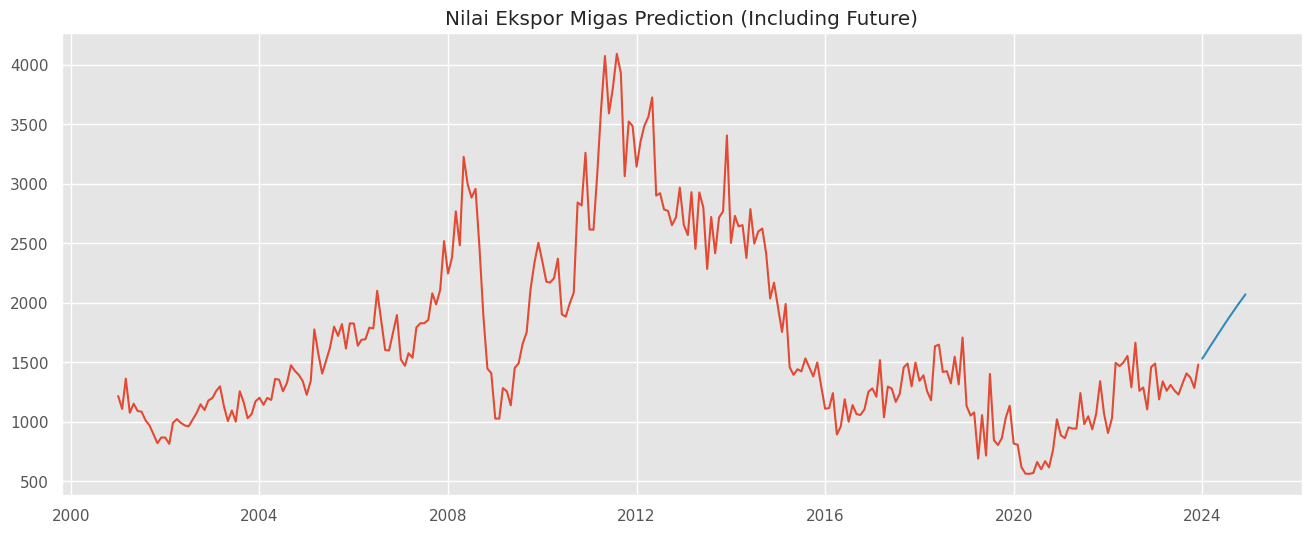

In [80]:
# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_data[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(16,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')

In [81]:
!pip install openpyxl

In [82]:
forecast_df.to_excel('forecast_data_h1t1.xlsx', index=False)
from google.colab import files
files.download('forecast_data_h1t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_data_h1t1.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_data_h1t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>